<a href="https://colab.research.google.com/github/yangtom0516/ML-project-stock-prediction/blob/main/ML_stock_price_prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# dataset at https://finance.yahoo.com/quote/TSLA/history?period1=1277818200&period2=1710547848

In [ ]:
import pandas as pd
# Pandas is a library that faciliates data analysihttps://docs.google.com/forms/d/e/1FAIpQLScqyn-MVGQkjiJoC4eOuWDvCH5cj4N5-mycD27GQtA0uayUtQ/viewforms and manipulation
df = pd.read_csv('TSLA 4-12-2024.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-04-13,182.960007,186.500000,180.940002,185.899994,185.899994,112933000
1,2023-04-14,183.949997,186.279999,182.009995,185.000000,185.000000,96438700
2,2023-04-17,186.320007,189.690002,182.690002,187.039993,187.039993,116662200
3,2023-04-18,187.149994,187.690002,183.580002,184.309998,184.309998,92067000
4,2023-04-19,179.100006,183.500000,177.649994,180.589996,180.589996,125732700
...,...,...,...,...,...,...,...
247,2024-04-08,169.339996,174.500000,167.789993,172.979996,172.979996,104423300
248,2024-04-09,172.910004,179.220001,171.919998,176.880005,176.880005,103232700
249,2024-04-10,173.039993,174.929993,170.009995,171.759995,171.759995,84532400
250,2024-04-11,172.550003,175.880005,168.509995,174.600006,174.600006,94516000


In [ ]:
df = df[['Date', 'Close']]
# only take the date and close columns
df

,Date,Close
0,2023-04-13,185.899994
1,2023-04-14,185.000000
2,2023-04-17,187.039993
3,2023-04-18,184.309998
4,2023-04-19,180.589996
...,...,...
247,2024-04-08,172.979996
248,2024-04-09,176.880005
249,2024-04-10,171.759995
250,2024-04-11,174.600006


In [ ]:
first_date_string = df.iat[3,0]
print(first_date_string)

last_date_string = df.iat[-1,0]
print(last_date_string)

2023-04-18
2024-04-12


In [ ]:
import datetime
# convert string into datetime
def str_to_datetime(x):
  split_list = x.split('-')
  year, month, day = int(split_list[0]), int(split_list[1]), int(split_list[2])
  return datetime.datetime(year = year, month = month, day = day)

datetime_obj = str_to_datetime(last_date_string)
datetime_obj += pd.Timedelta(days=1)
day_to_predict = str(datetime_obj).split()[0]
print(day_to_predict)





2024-04-13


In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime) # apply the function to each column of df
df['Date']

<ipython-input-90-f2875d9989b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime) # apply the function to each column of df


0     2023-04-13
1     2023-04-14
2     2023-04-17
3     2023-04-18
4     2023-04-19
         ...    
247   2024-04-08
248   2024-04-09
249   2024-04-10
250   2024-04-11
251   2024-04-12
Name: Date, Length: 252, dtype: datetime64[ns]

In [ ]:
df.index = df.pop('Date')
df

,Close
Date,
2023-04-13,185.899994
2023-04-14,185.000000
2023-04-17,187.039993
2023-04-18,184.309998
2023-04-19,180.589996
...,...
2024-04-08,172.979996
2024-04-09,176.880005
2024-04-10,171.759995


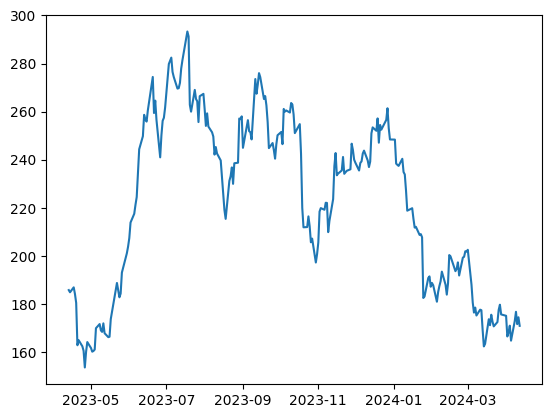

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['Close'])


In [ ]:
import numpy as np
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  second_date = str_to_datetime(last_date_str)

  target_date = first_date

  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

window_df = df_to_windowed_df(df, first_date_string, last_date_string, n=3)
window_df




,Target Date,Target-3,Target-2,Target-1,Target
0,2023-04-18,185.899994,185.000000,187.039993,184.309998
1,2023-04-19,185.000000,187.039993,184.309998,180.589996
2,2023-04-20,187.039993,184.309998,180.589996,162.990005
3,2023-04-21,184.309998,180.589996,162.990005,165.080002
4,2023-04-24,180.589996,162.990005,165.080002,162.550003
...,...,...,...,...,...
244,2024-04-08,168.380005,171.110001,164.899994,172.979996
245,2024-04-09,171.110001,164.899994,172.979996,176.880005
246,2024-04-10,164.899994,172.979996,176.880005,171.759995
247,2024-04-11,172.979996,176.880005,171.759995,174.600006


In [ ]:
def windowed_df_date_X_y(windowed_dataframe):
  df_to_np = windowed_dataframe.to_numpy()

  # first column : dates
  dates = df_to_np[:, 0]

  # all the rows and the middle three columns
  middle_matrix = df_to_np[:, 1:-1]

  prediction_matrix = df_to_np[-1, 2:]

  # input matrix X
  # len(dates): number of observations
  # shape[1]: the same number of columns as the windowed_dataframe
  # '1': univariate forcasting (only the closing price is considered)
  X = middle_matrix.reshape(len(dates), middle_matrix.shape[1], 1)
  prediction = prediction_matrix.reshape(1, 3, 1)

  # output vector: all the rows and only the last column
  Y = df_to_np[:, -1]

  return dates, X.astype(np.float32), prediction.astype(np.float32), Y.astype(np.float32)

dates,X,prediction,y = windowed_df_date_X_y(window_df)
dates.shape, X.shape, prediction.shape,y.shape



((249,), (249, 3, 1), (1, 3, 1), (249,))

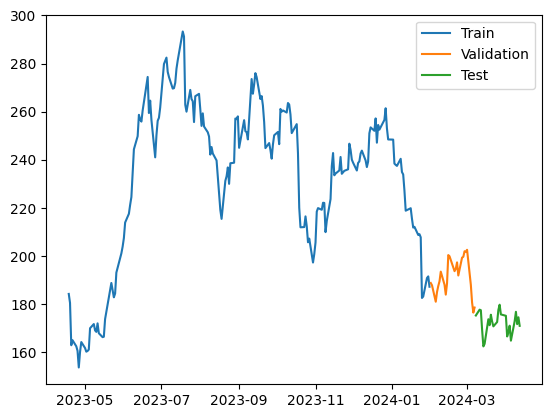

In [ ]:
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

# the first eighty percent of data will be training data
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

# validation
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

# test
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # sequential model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers # built up of many layers
import numpy as np
tf.keras.utils.set_random_seed(
    0
)

# sequential model, 3: previous three days, 1: univariate forcasting
model = Sequential([layers.Input((3,1)),
                   layers.LSTM(64),
                   layers.Dense(32, activation = 'relu'),
                   layers.Dense(32, activation = 'relu'),
                   layers.Dense(1)])

# loss function = mean square error
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)




Epoch 1/100
7/7 [==============================] - 4s 107ms/step - loss: 54836.7891 - mean_absolute_error: 231.8306 - val_loss: 36406.5039 - val_mean_absolute_error: 190.6519
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 54690.4180 - mean_absolute_error: 231.5137 - val_loss: 36280.2812 - val_mean_absolute_error: 190.3206
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 54523.9062 - mean_absolute_error: 231.1525 - val_loss: 36112.7734 - val_mean_absolute_error: 189.8800
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 54291.8945 - mean_absolute_error: 230.6460 - val_loss: 35865.0781 - val_mean_absolute_error: 189.2266
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 53948.2695 - mean_absolute_error: 229.9048 - val_loss: 35534.3164 - val_mean_absolute_error: 188.3506
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 53500.5742 - mean_absolute_error: 228.9323 - val_loss: 35

7/7 [==============================] - 1s 5ms/step


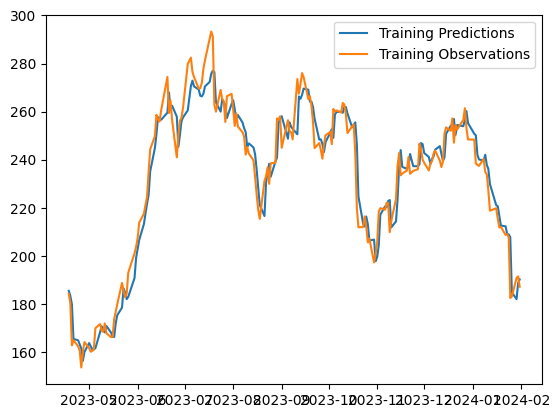

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 39ms/step


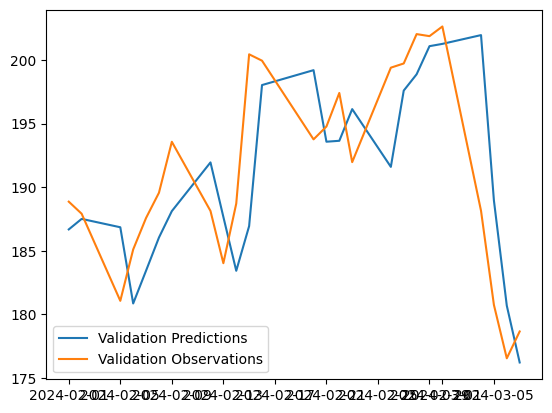

In [ ]:
validation_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])


1/1 [==============================] - 0s 40ms/step


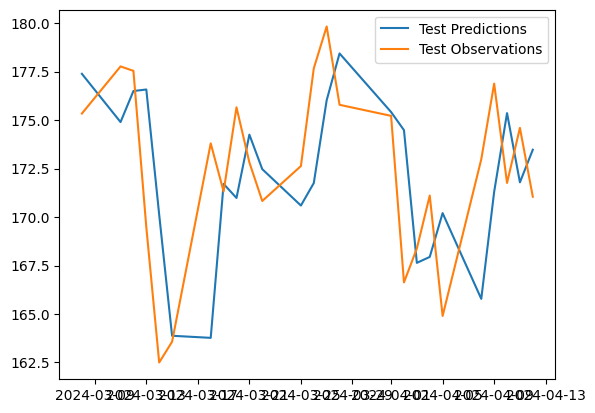

In [ ]:

test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])

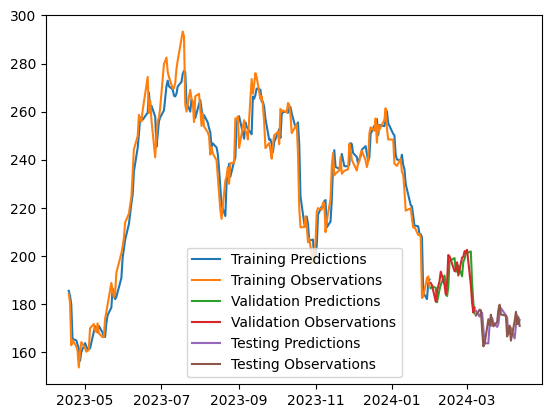

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

In [ ]:
test_predictions = model.predict(prediction).flatten()
str_to_print = "Prediction for " + day_to_predict + ": " + str(test_predictions);
print(str_to_print)

1/1 [==============================] - 0s 33ms/step
Prediction for 2024-04-13: [170.94829]
